In [32]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/AMZzee/mobilenet_v1.zip -O mobilenet_v1.zip

--2024-01-22 08:31:22--  https://cainvas-static.s3.amazonaws.com/media/user_data/AMZzee/mobilenet_v1.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.160.171, 52.219.160.143, 52.219.160.3, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.160.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9263 (9.0K) [application/x-zip-compressed]
Saving to: ‘mobilenet_v1.zip’

mobilenet_v1.zip    100%[===================>]   9.05K  --.-KB/s    in 0s      

2024-01-22 08:31:23 (77.6 MB/s) - ‘mobilenet_v1.zip’ saved [9263/9263]



In [33]:
import zipfile as zf
files = zf.ZipFile("mobilenet_v1.zip", 'r')
files.extractall('mobilenet_v1')
files.close()

In [3]:
from tensorflow import keras
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten
import matplotlib.pyplot as plt
import cv2

from mobilenet_v1.mobilenet import MobileNet

from tensorflow.keras.applications.mobilenet import preprocess_input

In [4]:
# the parameters
IMAGE_SIZE = 224 #224x224 pixels
ALPHA=0.75
EPOCHS=20

**Images used for Training and Testing are pre-processed as follows:**

In [5]:
def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

**Building the Model — Transfer Learning**

In [6]:
# function to define dropout, hidden layers and the number of output
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x)
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x)

    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

**Loading MobileNet:**

In [7]:
# Using MobileNetv1
base_model=MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE,3), alpha = ALPHA,
                     depth_multiplier = 1, dropout = 0.001, include_top = False,
                     weights = "imagenet", classes = 4, backend=keras.backend,
                     layers=keras.layers,models=keras.models,utils=keras.utils)

10626956/10626956 [==============================] - 0s 0us/step


In [8]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/AMZzee/3D_Shapes.zip -O 3D_Shapes.zip

--2024-01-22 07:33:21--  https://cainvas-static.s3.amazonaws.com/media/user_data/AMZzee/3D_Shapes.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 16.12.36.139, 3.5.210.253, 52.219.66.40, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|16.12.36.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2137601 (2.0M) [application/x-zip-compressed]
Saving to: ‘3D_Shapes.zip’

3D_Shapes.zip       100%[===================>]   2.04M  1.57MB/s    in 1.3s    

2024-01-22 07:33:24 (1.57 MB/s) - ‘3D_Shapes.zip’ saved [2137601/2137601]



**3D Shapes Dataset**

In [9]:
import zipfile as zf
files = zf.ZipFile("3D_Shapes.zip", 'r')
files.extractall('3D_Shapes_Dataset')
files.close()

In [10]:
FC_LAYERS = [100, 50]
dropout = 0.5

finetune_model = build_finetune_model(base_model,
                                      dropout=dropout,
                                      fc_layers=FC_LAYERS,
                                      num_classes=4)

**Training the Model — Fine-Tuning**

In [11]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator=train_datagen.flow_from_directory('3D_Shapes_Dataset',
                                                 target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical', shuffle=True)

Found 1182 images belonging to 4 classes.


**Fitting into the model**

In [12]:
finetune_model.summary()
finetune_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
step_size_train=train_generator.n//train_generator.batch_size
history = finetune_model.fit_generator(generator=train_generator,steps_per_epoch=step_size_train,epochs=EPOCHS, shuffle=True)

finetune_model.save('shape_model.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 226, 226, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 24)      648       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 24)      96        
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 24)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 24)      216       
 )                                                           

<ipython-input-12-ad3e89ccc49c>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = finetune_model.fit_generator(generator=train_generator,steps_per_epoch=step_size_train,epochs=EPOCHS, shuffle=True)


Epoch 1/20
36/36 [==============================] - 38s 1s/step - loss: 1.2555 - accuracy: 0.5113
Epoch 2/20
36/36 [==============================] - 35s 982ms/step - loss: 0.4991 - accuracy: 0.8261
Epoch 3/20
36/36 [==============================] - 36s 1s/step - loss: 0.2713 - accuracy: 0.9104
Epoch 4/20
36/36 [==============================] - 33s 920ms/step - loss: 0.1827 - accuracy: 0.9401
Epoch 5/20
36/36 [==============================] - 46s 1s/step - loss: 0.1276 - accuracy: 0.9574
Epoch 6/20
36/36 [==============================] - 37s 1s/step - loss: 0.0868 - accuracy: 0.9791
Epoch 7/20
36/36 [==============================] - 37s 1s/step - loss: 0.0813 - accuracy: 0.9783
Epoch 8/20
36/36 [==============================] - 34s 923ms/step - loss: 0.0669 - accuracy: 0.9817
Epoch 9/20
36/36 [==============================] - 36s 995ms/step - loss: 0.0550 - accuracy: 0.9843
Epoch 10/20
36/36 [==============================] - 37s 1s/step - loss: 0.0482 - accuracy: 0.9852
Epoch 1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Representation of loss & accuracy**

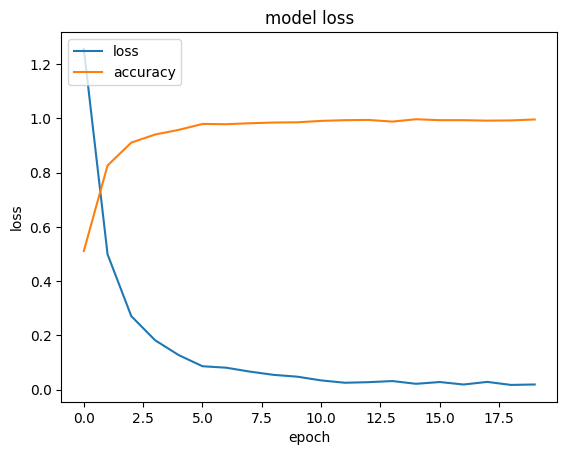

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

In [14]:
def predict_shape(img_path):
#img_path="3D_Shapes_Dataset/cube/00000963.jpg"
    preprocessed_image = prepare_image(img_path)
    predictions_shape = finetune_model.predict(preprocessed_image)
    labels=['Cube','Cylinder','Spheroid','Sphere']
    #print("Input Image :")
    img=cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    print("Shape Detected: ", labels[predictions_shape[0].tolist().index(max(predictions_shape[0]))])

**Testing the Model**

1/1 [==============================] - 1s 603ms/step
Shape Detected:  Cube


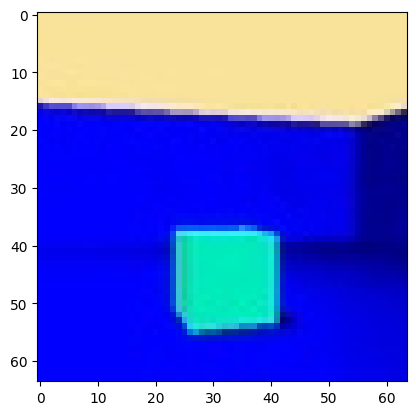

In [15]:
img_path="3D_Shapes_Dataset/cube/00000963.jpg"
predict_shape(img_path)

In [16]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/AMZzee/IMG_20210626_141530.jpg -O sample1.jpg

--2024-01-22 07:52:17--  https://cainvas-static.s3.amazonaws.com/media/user_data/AMZzee/IMG_20210626_141530.jpg
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 16.12.40.27, 52.219.158.119, 52.219.158.39, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|16.12.40.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3324161 (3.2M) [image/jpeg]
Saving to: ‘sample1.jpg’

sample1.jpg         100%[===================>]   3.17M  1.83MB/s    in 1.7s    

2024-01-22 07:52:20 (1.83 MB/s) - ‘sample1.jpg’ saved [3324161/3324161]



1/1 [==============================] - 0s 49ms/step
Shape Detected:  Spheroid


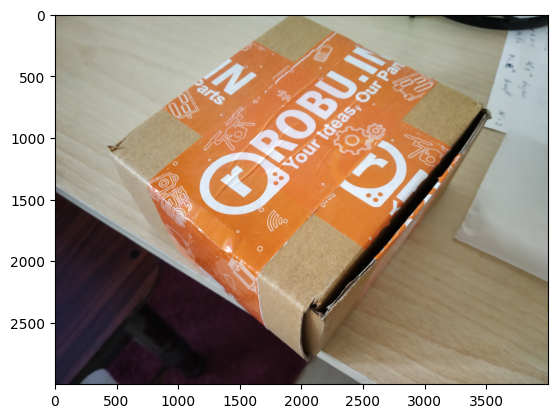

In [17]:
# Real-Life example
img_path="sample1.jpg"
predict_shape(img_path)

In [18]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/AMZzee/sample2.jpg -O sample2.jpg

--2024-01-22 07:52:30--  https://cainvas-static.s3.amazonaws.com/media/user_data/AMZzee/sample2.jpg
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.160.211, 52.219.158.195, 52.219.156.143, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.160.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4902153 (4.7M) [image/jpeg]
Saving to: ‘sample2.jpg’

sample2.jpg         100%[===================>]   4.67M  2.70MB/s    in 1.7s    

2024-01-22 07:52:33 (2.70 MB/s) - ‘sample2.jpg’ saved [4902153/4902153]



1/1 [==============================] - 0s 46ms/step
Shape Detected:  Spheroid


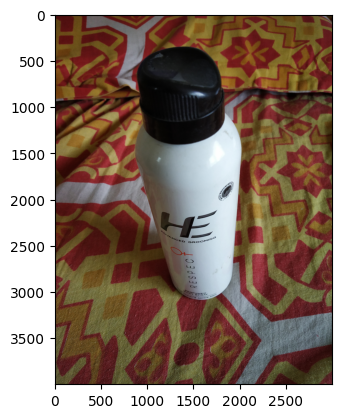

In [19]:
# Real-Life example 2
img_path="sample2.jpg"
predict_shape(img_path)

In [20]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/AMZzee/sample3.jpg -O sample3.jpg

--2024-01-22 07:52:48--  https://cainvas-static.s3.amazonaws.com/media/user_data/AMZzee/sample3.jpg
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 16.12.36.95, 52.219.158.127, 52.219.158.35, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|16.12.36.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25853 (25K) [image/jpeg]
Saving to: ‘sample3.jpg’

sample3.jpg         100%[===================>]  25.25K   116KB/s    in 0.2s    

2024-01-22 07:52:49 (116 KB/s) - ‘sample3.jpg’ saved [25853/25853]



1/1 [==============================] - 0s 45ms/step
Shape Detected:  Sphere


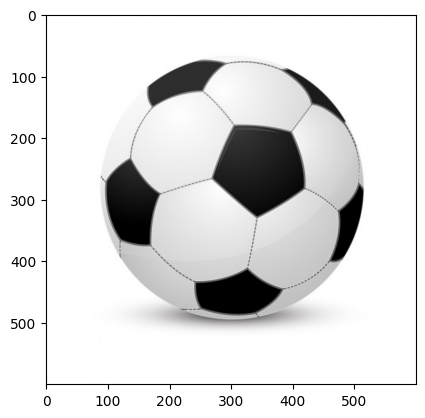

In [21]:
# Real-Life example 3
img_path="sample3.jpg"
predict_shape(img_path)

In [22]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/AMZzee/sample4.jpg -O sample4.jpg

--2024-01-22 07:52:59--  https://cainvas-static.s3.amazonaws.com/media/user_data/AMZzee/sample4.jpg
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.156.179, 52.219.160.135, 52.219.158.91, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.156.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12481 (12K) [image/jpeg]
Saving to: ‘sample4.jpg’

sample4.jpg         100%[===================>]  12.19K  --.-KB/s    in 0s      

2024-01-22 07:53:00 (53.7 MB/s) - ‘sample4.jpg’ saved [12481/12481]



1/1 [==============================] - 0s 43ms/step
Shape Detected:  Cylinder


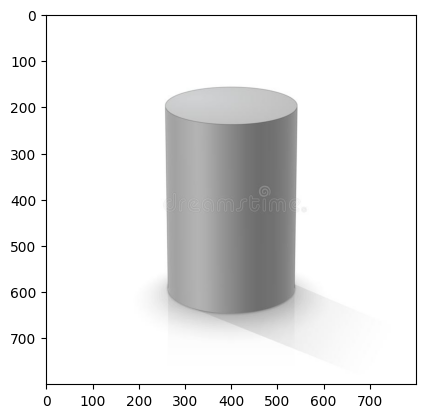

In [23]:
# Real-Life example 4
img_path="sample4.jpg"
predict_shape(img_path)

1/1 [==============================] - 0s 53ms/step
Shape Detected:  Sphere


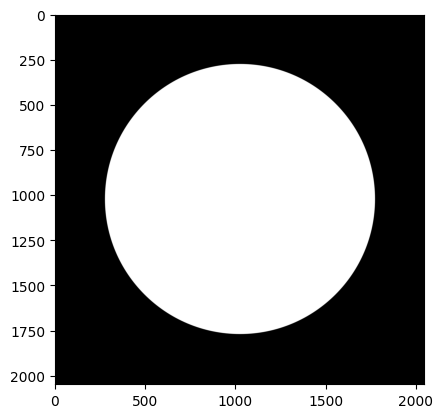

In [ ]:
img_path="/content/Circle-image.svg.png"
predict_shape(img_path)

1/1 [==============================] - 0s 45ms/step
Shape Detected:  Spheroid


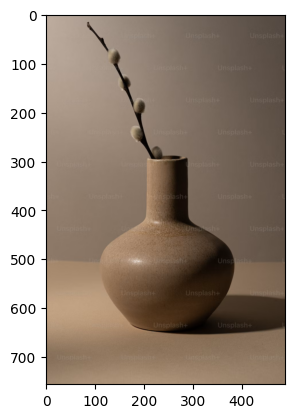

In [24]:
img_path="/content/pot.png"
predict_shape(img_path)

1/1 [==============================] - 0s 44ms/step
Shape Detected:  Spheroid


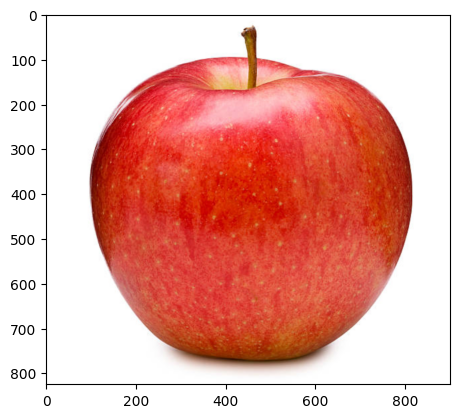

In [25]:
img_path="/content/Apple.png"
predict_shape(img_path)

1/1 [==============================] - 0s 44ms/step
Shape Detected:  Spheroid


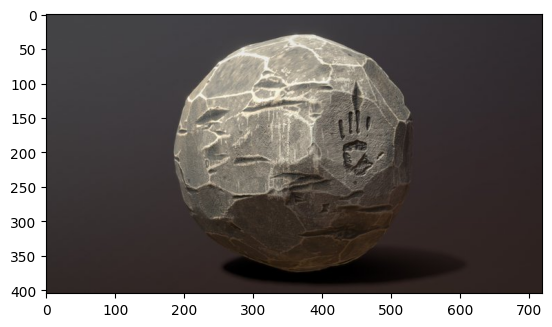

In [26]:
img_path="/content/spheroid_example1.jpeg"
predict_shape(img_path)

1/1 [==============================] - 0s 66ms/step
Shape Detected:  Cylinder


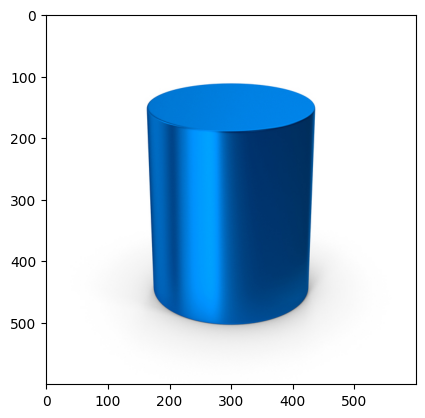

In [27]:
img_path="/content/cylinder-blue-metallic-o0JNna9-600.jpg"
predict_shape(img_path)

1/1 [==============================] - 0s 44ms/step
Shape Detected:  Cube


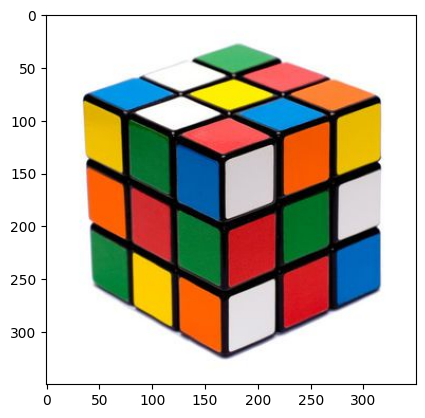

In [28]:
img_path="/content/cube example.jpg"
predict_shape(img_path)

1/1 [==============================] - 0s 201ms/step
Shape Detected:  Spheroid


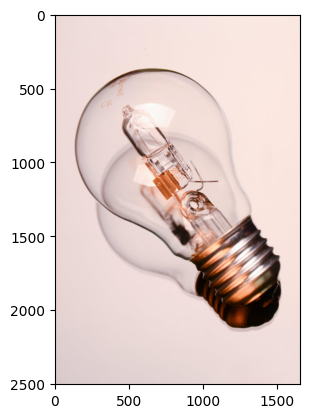

In [34]:
img_path="/content/bulb_example.jpg"
predict_shape(img_path)

1/1 [==============================] - 0s 55ms/step
Shape Detected:  Spheroid


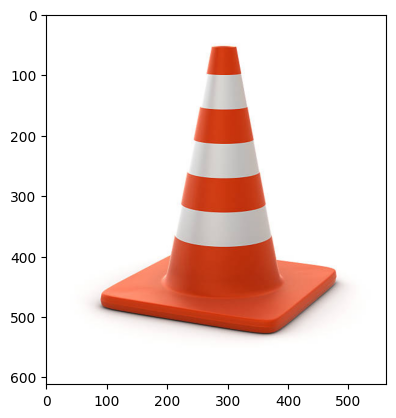

In [35]:
img_path="/content/istockphoto-174543792-612x612.jpg"
predict_shape(img_path)

webcam


In [ ]:
import cv2
from tensorflow.keras.models import load_model

In [ ]:
# Load the pre-trained model
finetune_model = load_model('shape_model.h5')



In [ ]:
# Live Object Shape Detection
import cv2
from tensorflow.keras.models import load_model

# Load the pre-trained model
finetune_model = load_model('shape_model.h5')

def predict_live_shape(frame):
    try:
        # Preprocess the frame
        preprocessed_frame = cv2.resize(frame, (IMAGE_SIZE, IMAGE_SIZE))
        preprocessed_frame = np.expand_dims(preprocessed_frame, axis=0)
        preprocessed_frame = preprocess_input(preprocessed_frame)

        # Make predictions
        predictions_shape = finetune_model.predict(preprocessed_frame)
        labels = ['Cube', 'Cylinder', 'Spheroid', 'Sphere']

        # Display the frame and predicted shape
        cv2.imshow('Live Object Shape Detection', frame)
        print("Shape Detected: ", labels[predictions_shape[0].argmax()])
    except Exception as e:
        print("Error:", str(e))

cap = cv2.VideoCapture(0)




In [ ]:
while True:
    # Read a frame from the webcam
    ret, frame = cap.read()

    # Check if the frame is valid
    if not ret:
        print("Error: Could not read frame")
        break

    # Predict the shape
    predict_live_shape(frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()


Error: Could not read frame
